# Installing and importing libs

In [1]:
!pip install jdatetime

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import jdatetime, datetime, json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Reading excel file for transaction

First, we need to assign the name or address of the excel file from which we want to read the transactions.

In [3]:
transactionsFileAddress = "transactions.xlsx"

In [4]:
df = pd.read_excel(transactionsFileAddress, skiprows=2, header=None, 
                   names=["Date", "Detail", "NegativeTransaction", "PositiveTransaction", "Remain", "Branch"])[:-1]

df.head(3)

,Date,Detail,NegativeTransaction,PositiveTransaction,Remain,Branch
0,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-3800-14020716 1...",0,33945002,68287362.0,صحرا - اختیار معامله
1,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-4000-14020716 2...",0,39958800,108246162.0,صحرا - اختیار معامله
2,1402/03/23,"فروش 4,000 سهم اختيارخ خودرو-5000-1402/04/07 ...",0,39960,108286122.0,صحرا - اختیار معامله


# Processing and cleaning the data

In [5]:
# Breaking down detail row into its parts
def getDetailRowBrokenDown(df):
    pattern = r"(?P<Side>\w+)\s+(?P<Quantity>[\d,]+) (?:مشاركت|سهم|واحد|تقدم) (?P<InstrumentName>[\w\d\s/\(\)\u200c,.-]+)(?=[\s]{2,}(?P<Price>[\d,]+))"
    return df['Detail'].str.extract(pattern)
df = pd.concat([df, getDetailRowBrokenDown(df)], axis=1)

In [6]:
# Checking out the rows that do not follow the pattern
df_exceptional = df[df.isnull().any(axis=1)]
df_exceptional

,Date,Detail,NegativeTransaction,PositiveTransaction,Remain,Branch,Side,Quantity,InstrumentName,Price
21,1402/03/23,دريافت واريز 000 سامان,0,900000000,936046940.0,تهران-اصلی,NaN,NaN,NaN,NaN


In [7]:
# Filtering the exceptional rows
df.dropna(inplace=True)
df

,Date,Detail,NegativeTransaction,PositiveTransaction,Remain,Branch,Side,Quantity,InstrumentName,Price
0,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-3800-14020716 1...",0,33945002,6.828736e+07,صحرا - اختیار معامله,فروش,"20,000",اختيارخ خاور-3800-14020716,"1,699"
1,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-4000-14020716 2...",0,39958800,1.082462e+08,صحرا - اختیار معامله,فروش,"20,000",اختيارخ خاور-4000-14020716,"2,000"
2,1402/03/23,"فروش 4,000 سهم اختيارخ خودرو-5000-1402/04/07 ...",0,39960,1.082861e+08,صحرا - اختیار معامله,فروش,"4,000",اختيارخ خودرو-5000-1402/04/07,10
3,1402/03/23,"فروش 1,000 سهم اختيارخ دي-1800-14020518 150 ...",0,149846,1.084360e+08,صحرا - اختیار معامله,فروش,"1,000",اختيارخ دي-1800-14020518,150
4,1402/03/23,"فروش 51,000 سهم اختيارخ دي-2000-14020518 متوس...",0,4785068,1.132210e+08,صحرا - اختیار معامله,فروش,"51,000",اختيارخ دي-2000-14020518 متوسط,94
...,...,...,...,...,...,...,...,...,...,...
171,1402/05/18,"خريد 7,545 سهم اختيارخ فولاد-5463-1402/07/26 ...",-2643468,0,2.539965e+09,صحرا - اختیار معامله,خريد,"7,545",اختيارخ فولاد-5463-1402/07/26,350
172,1402/05/22,"فروش 147,000 سهم اختيارخ اهرم-7500-1402/07/23 ...",0,1600949322,4.140914e+09,صحرا - اختیار معامله,فروش,"147,000",اختيارخ اهرم-7500-1402/07/23 متوسط,"10,902"
173,1402/05/22,"فروش 200,000 سهم اختيارخ شستا-800-1402/08/03 ...",0,83913480,4.224828e+09,صحرا - اختیار معامله,فروش,"200,000",اختيارخ شستا-800-1402/08/03 متوسط,420
174,1402/05/22,"خريد 4,000 سهم اختيارخ اهرم-6500-1402/07/23 ...",-44045320,0,4.180782e+09,صحرا - اختیار معامله,خريد,"4,000",اختيارخ اهرم-6500-1402/07/23,"11,000"


In [8]:
# Processing some rows
df["Quantity"] = pd.to_numeric(df["Quantity"].replace(',','', regex=True))
df["Price"] = pd.to_numeric(df["Price"].replace(',','', regex=True))
df["Value"] = df["Quantity"] * df["Price"]

# Removing the word "متوسط" from InstrumentName since some of the rows in the excel may contain this word before price
def InstrumentNameTrimmer(x):
    x = x.removesuffix(' متوسط')
    x = x.removesuffix(' ')
    return x
df["InstrumentName"] = df["InstrumentName"].apply(InstrumentNameTrimmer)

# Changing the side indicator to its English equivalent
def SideProcessor(x):
    if x == "فروش":
        return "Sell"
    elif x == "خريد":
        return "Buy"
    else:
        return None
df["Side"] = df["Side"].apply(SideProcessor)

df.reset_index(inplace=True, drop=True)

In [9]:
df.head()

,Date,Detail,NegativeTransaction,PositiveTransaction,Remain,Branch,Side,Quantity,InstrumentName,Price,Value
0,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-3800-14020716 1...",0,33945002,68287362.0,صحرا - اختیار معامله,Sell,20000,اختيارخ خاور-3800-14020716,1699,33980000
1,1402/03/23,"فروش 20,000 سهم اختيارخ خاور-4000-14020716 2...",0,39958800,108246162.0,صحرا - اختیار معامله,Sell,20000,اختيارخ خاور-4000-14020716,2000,40000000
2,1402/03/23,"فروش 4,000 سهم اختيارخ خودرو-5000-1402/04/07 ...",0,39960,108286122.0,صحرا - اختیار معامله,Sell,4000,اختيارخ خودرو-5000-1402/04/07,10,40000
3,1402/03/23,"فروش 1,000 سهم اختيارخ دي-1800-14020518 150 ...",0,149846,108435968.0,صحرا - اختیار معامله,Sell,1000,اختيارخ دي-1800-14020518,150,150000
4,1402/03/23,"فروش 51,000 سهم اختيارخ دي-2000-14020518 متوس...",0,4785068,113221036.0,صحرا - اختیار معامله,Sell,51000,اختيارخ دي-2000-14020518,94,4794000


___
By now, we have all the trades in a clean processed format.
___

However, for the sake of analysis, we need to find the trades that are unsettled and remove them from our dataframe. The unsettled trades may exist because of a handful of reasons, such as the account's portfolio prior to the report's start date and the account's remaining asset after the report's finishing date. To this end, we will construct a daily portfolio from the available transactions and find the ones remaining in the end. Afterwards, we will find the last date when each of these instruments were settled, and we will finally remove all the transactions from these unsettled instruments after the aforementioned dates. 

# Preparing data for analysis

In [10]:
# Date processor methods

# Converts Jalali date in the format of "1402/05/25" into a datetime.date object
def getGregorianDate(jllString):
    jllParts = jllString.split("/")
    return jdatetime.date(int(jllParts[0]),int(jllParts[1]),int(jllParts[2])).togregorian()

# Returns the number of dates between two Jalali dates of the format "1402/05/25"
def getDaysBetweenDates(start, finish):
    return (getGregorianDate(finish) - getGregorianDate(start)).days

# Converts datetime.date object to Jalali date of format "1402/05/25"
def getJalaliFromGreogorian(date):
    d = jdatetime.date.fromgregorian(date=date)
    return f"{d.year}/{d.month:02}/{d.day:02}"


In [11]:
# Finding the unsettled records to exclude
def getDateBeforeStart(df):
    minDate = df["Date"][0]
    minDateGregorian = getGregorianDate(minDate)
    beforeDateGregorian = minDateGregorian + datetime.timedelta(days=-1)
    return getJalaliFromGreogorian(beforeDateGregorian)

LastDateBeforeStart = getDateBeforeStart(df)
last_date = LastDateBeforeStart
DailyPortfolio = {last_date: {}}

for i in range(len(df)):
    date = df["Date"][i]
    if date not in DailyPortfolio.keys():
        DailyPortfolio[date] = DailyPortfolio[last_date].copy()
        last_date = date
    instrumentName = df["InstrumentName"][i]
    if instrumentName not in DailyPortfolio[date].keys():
        DailyPortfolio[date][instrumentName] = 0
    DailyPortfolio[date][instrumentName] += (1 if df["Side"][i] == "Buy" else -1) * df["Quantity"][i]

for date in DailyPortfolio.keys():
    date_keys = list(DailyPortfolio[date].keys())
    for instrument in date_keys:
        if DailyPortfolio[date][instrument] == 0:
            del DailyPortfolio[date][instrument]

instrumentsToExcludeAfterDate = {}
allDates = list(DailyPortfolio.keys())
for instrument in DailyPortfolio[last_date]:
    instrumentsToExcludeAfterDate[instrument] = allDates[0]
    for date in allDates[::-1]:
        if instrument not in DailyPortfolio[date]:
            instrumentsToExcludeAfterDate[instrument] = date
            break
    
recordsToExclude = []
for i in range(len(df)):
    if df["InstrumentName"][i] in instrumentsToExcludeAfterDate.keys():
        if df["Date"][i] > instrumentsToExcludeAfterDate[df["InstrumentName"][i]]:
            recordsToExclude.append(i)
            
print(f"We have a total of {len(df)} records that {len(recordsToExclude)} of them are unsettled.")
df.drop(recordsToExclude, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

We have a total of 175 records that 36 of them are unsettled.


# Analysis

In [12]:
BuyNum = len(df[df["Side"] == "Buy"])
SellNum = len(df[df["Side"] == "Sell"]["Value"])

print(f"BuyNum is {BuyNum}, SellNum is {SellNum}")

BuyNum is 66, SellNum is 73


In [13]:
BuySum = df[df["Side"] == "Buy"]["Value"].sum()
SellSum = df[df["Side"] == "Sell"]["Value"].sum()

print(f"Sum of the trades on the buy side : {BuySum:,}")
print(f"Sum of the trades on the sell side : {SellSum:,}")
print(f"Net realised profit : {SellSum - BuySum:,}")
print(f"Total trade volume : {SellSum + BuySum:,}")

Sum of the trades on the buy side : 12,212,692,662
Sum of the trades on the sell side : 15,064,708,047
Net realised profit : 2,852,015,385
Total trade volume : 27,277,400,709


<h4>Extracting the daily trends</h4>

In [14]:
# This rather elaborate method extracts the daily trends consisting of:\
# portfolio, realised profit, and excess investment at the end of the day
def extractDailyDataFromDataFrame(df):
    DailyData = {} # "_date_" : {"Profit": 0, "Investment": 0, "Portfolio": {}}

    portfolio = {} # "_Instrument_" : {"Quantity":0, "Value":0}
    investment = 0
    profit = 0
    last_date = df["Date"][0]

    for i in range(len(df)):
        instrument = df["InstrumentName"][i]
        date = df["Date"][i]
        if date != last_date:
            DailyData[last_date] = {
                "Profit": profit,
                "Investment": investment,
                "Portfolio": dict([(key, portfolio[key].copy()) for key in portfolio.keys()])
            }
            last_date = date
        value = (1 if df["Side"][i] == "Buy" else -1) * df["Value"][i]
        quantity = (1 if df["Side"][i] == "Buy" else -1) * df["Quantity"][i]
        if instrument in portfolio.keys():
            if portfolio[instrument]["Quantity"] * quantity > 0:
                portfolio[instrument]["Quantity"] += quantity
                portfolio[instrument]["Value"] += value
                investment += abs(value)
            else:
                if abs(quantity) <= abs(portfolio[instrument]["Quantity"]):
                    settledInvestment = int(-portfolio[instrument]["Value"] * quantity/portfolio[instrument]["Quantity"])
                    investment -= abs(settledInvestment)
                    profit += - settledInvestment - value
                    portfolio[instrument]["Value"] -= settledInvestment
                    portfolio[instrument]["Quantity"] += quantity
                else:
                    settledValue = int(-value * portfolio[instrument]["Quantity"] / quantity)
                    profit += - portfolio[instrument]["Value"] - settledValue
                    investment -= abs(portfolio[instrument]["Value"])
                    newInvested = value - settledValue
                    portfolio[instrument]["Quantity"] += quantity
                    portfolio[instrument]["Value"] = newInvested
                    investment += abs(newInvested)                
            if portfolio[instrument]["Quantity"] == 0:
                del portfolio[instrument]
        else:
            portfolio[instrument] = {"Quantity": quantity, "Value": value}
            investment += abs(value)

    DailyData[last_date] = {
        "Profit": profit,
        "Investment": investment,
        "Portfolio": dict([(key, portfolio[key].copy()) for key in portfolio.keys()])
    }
    for key in DailyData.keys():
        DailyData[key]["TradeValue"] = df[df["Date"] == key]["Value"].sum()
    return DailyData

DailyData = extractDailyDataFromDataFrame(df)

The following cell makes an estimation of the max investment needed to make this trades. Subtracting the cummulated profits from the investment amount, one can get the extra cash needed at the end of each day to make the trades.

In [15]:
DailyExcessInvestment = [DailyData[key]["Investment"] - DailyData[key]["Profit"] for key in DailyData.keys()]
print(f"Max investment needed for realizing this trend is {max(DailyExcessInvestment)}.")

Max investment needed for realizing this trend is 363727550.


___
<h4>Market Index</h4>
<p>We use total market index as a benchline in our plots. In order to do so, we download the overal market index (<em>شاخص کل</em>) data.</p>

In [16]:
!wget -O 32097828799138957 http://cdn.tsetmc.com/api/Index/GetIndexB2History/32097828799138957 

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2023-08-19 11:51:25--  http://cdn.tsetmc.com/api/Index/GetIndexB2History/32097828799138957
Resolving cdn.tsetmc.com... 94.182.184.228, 94.182.113.115, 46.102.143.218, ...
Connecting to cdn.tsetmc.com|94.182.184.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: `32097828799138957'

     0K .......... .......... .......... .......... ..........  290K
    50K .......... .......... .......... .......... ..........  592K
   100K .......... .......... .......... .......... .......... 4.06M
   150K .......... .......... .......... .......... ..........  733K
   200K .......... .......... .......... .......... ..........  976K
   250K .......... .......... .......... .......... .......... 4.40M
   300K .......... .......... .......... .......... .......... 4.77M
   350K .......... .......... .......... .......... .......... 3.

In [17]:
with open("32097828799138957") as file:
    market_index_raw = json.load(file)["indexB2"]
market_index = dict([
    (getJalaliFromGreogorian(datetime.date(year=row["dEven"]//10000,month=row["dEven"]//100%100,day=row["dEven"]%100)), 
     row["xNivInuClMresIbs"]) for row in market_index_raw])
market_index_days = list(market_index.keys())
market_index_day_before_start = market_index[market_index_days[market_index_days.index(df["Date"][0])-1]]

# Plots

Before ploting the charts, the amount of initial investment should be given in the parameter InitialInvestment. This amount is used to calculate the profits in percentages.

In [18]:
InitialInvestment = 900000000

In [19]:
# Calculating the Xs and Ys for the charts
xLabels = [i for i in DailyData.keys()]
xs = [getDaysBetweenDates(LastDateBeforeStart, i) for i in xLabels]
yProfits = [DailyData[i]["Profit"] for i in DailyData.keys()]
yInvestments = [DailyData[i]["Investment"] for i in DailyData.keys()]
yProfitCoefs = [i / InitialInvestment for i in yProfits]
yTradeValues = [DailyData[i]["TradeValue"] for i in DailyData.keys()]

yAverageBondReturnsCoefs = [pow(1.27,i/365) - 1.0 for i in xs]
yAverageBondReturns = [i * InitialInvestment for i in yAverageBondReturnsCoefs]

yMarketIndexProfitCoefs = [market_index[xl] / market_index_day_before_start - 1.0 for xl in xLabels]
yMarketIndexProfit = [i * InitialInvestment for i in yMarketIndexProfitCoefs]

In [20]:
#The method dayToJllDateFormatter is used to convert the x axis labels to their corresponding Jalili date
def dayToJllDateFormatter(x, pos):
    grgDate = getGregorianDate(xLabels[0]) + datetime.timedelta(days=x)
    return getJalaliFromGreogorian(grgDate)

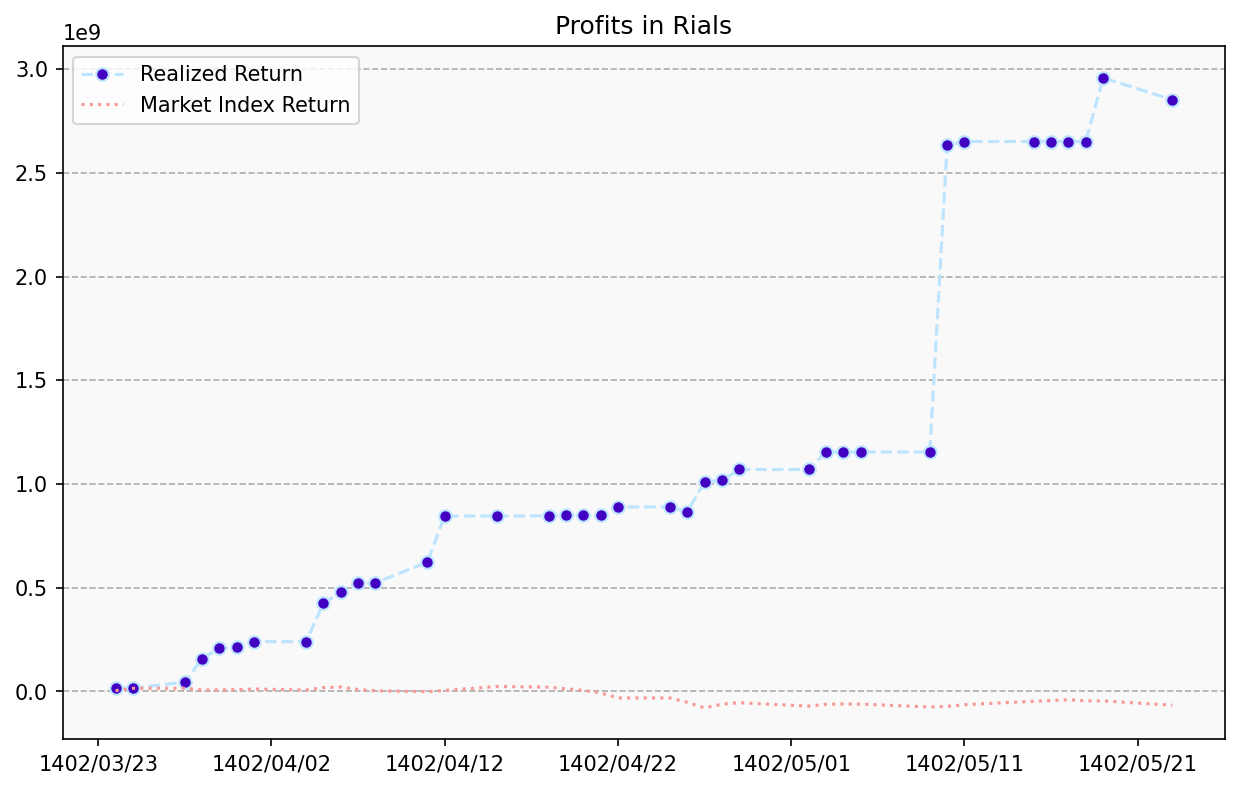

In [21]:
# Daily Profit Chart
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, yProfits, linestyle='--', marker='o', c='#bde4ff', markerfacecolor='#4100c2', label="Realized Return")
ax.plot(xs, yMarketIndexProfit, linestyle=':', c='#f79a97', label="Market Index Return")
ax.set_facecolor('#' + 'f9'*3)
ax.yaxis.grid(True, linestyle='--', c="#adadad")

ax.set_title('Profits in Rials')

ax.xaxis.set_major_formatter(FuncFormatter(dayToJllDateFormatter))
    
ax.legend(loc="upper left")
plt.show()


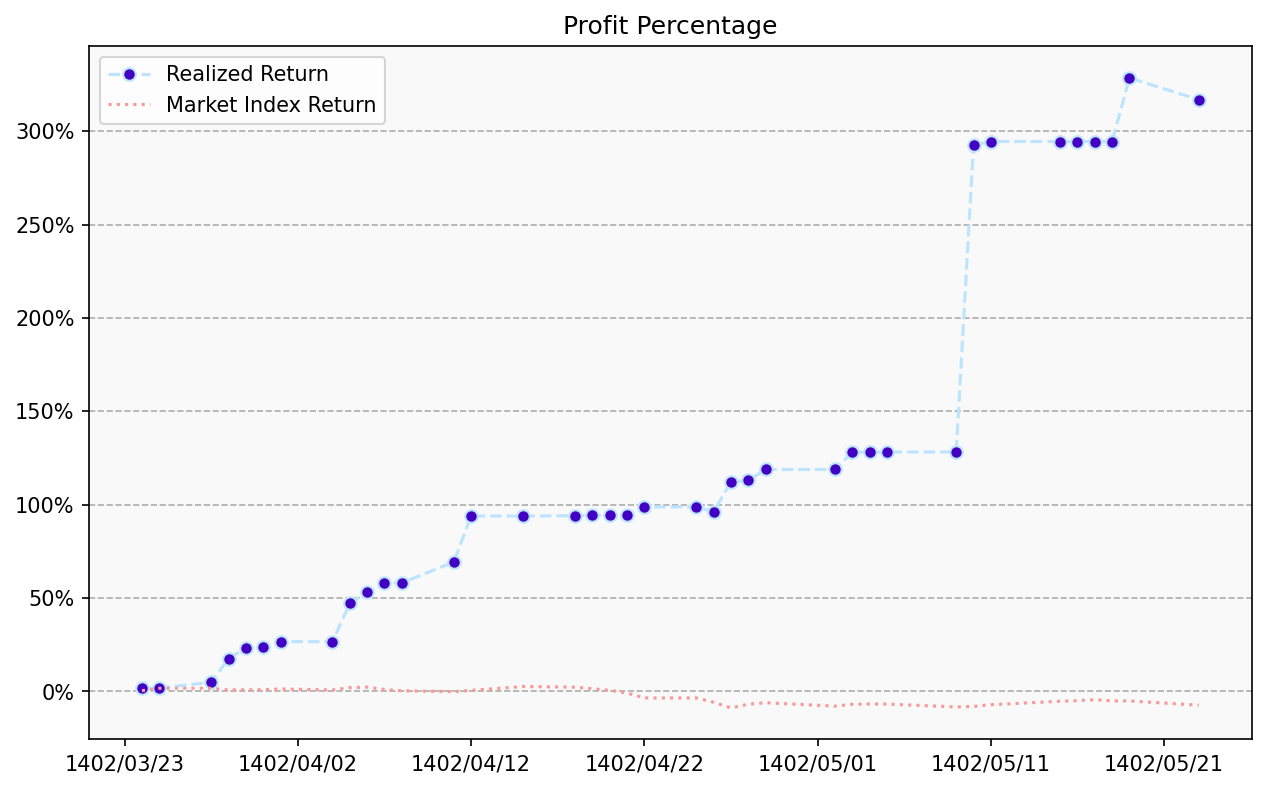

In [22]:
# Daily Profit Chart in Percentages
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, yProfitCoefs, linestyle='--', marker='o', c='#bde4ff', markerfacecolor='#4100c2', label="Realized Return")
ax.plot(xs, yMarketIndexProfitCoefs, linestyle=':', c='#f79a97', label="Market Index Return")
ax.set_facecolor('#' + 'f9'*3)
ax.yaxis.grid(True, linestyle='--', c="#adadad")

# Set labels for x and y axes
ax.set_title('Profit Percentage')

ax.xaxis.set_major_formatter(FuncFormatter(dayToJllDateFormatter))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y_val, pos: f"{y_val*100:0.0f}%"))
    
ax.legend(loc="upper left")
plt.show()


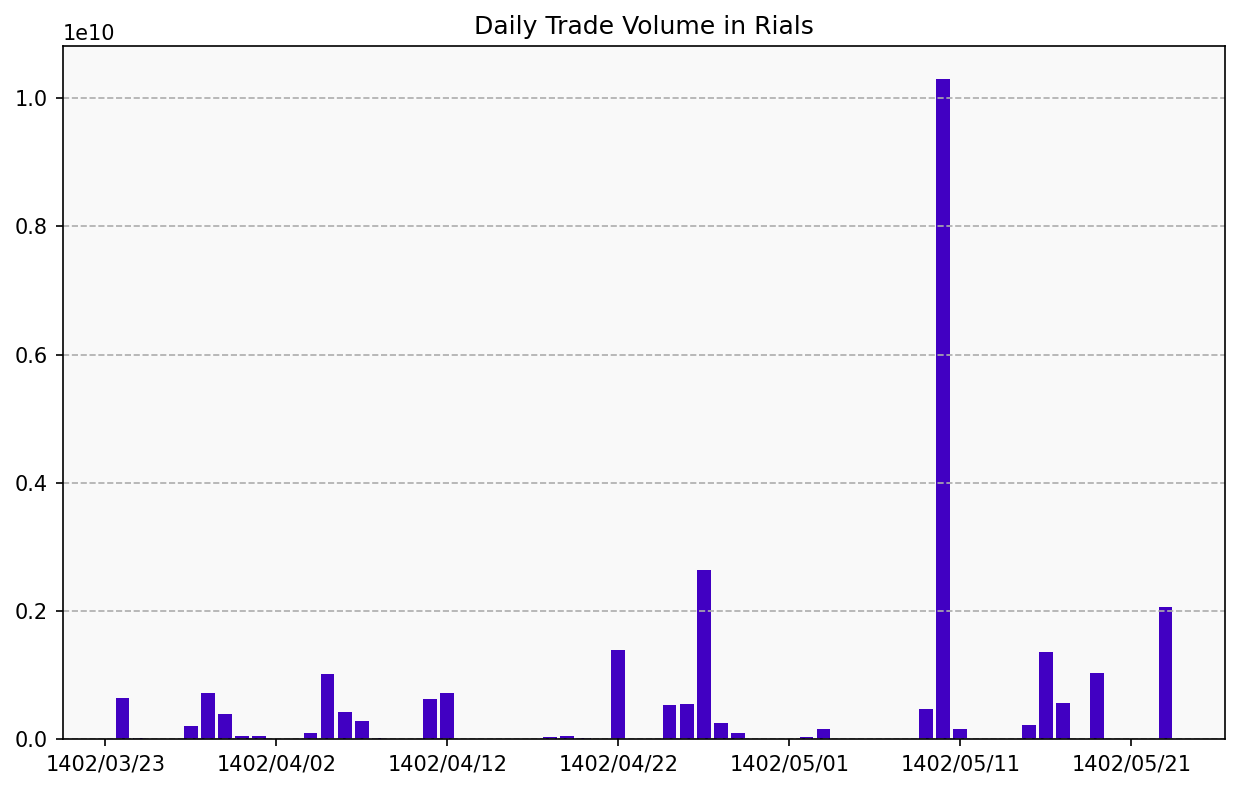

In [23]:
# Daily Trade Volume Chart
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.bar(xs, yTradeValues, color="#4100c2")
ax.set_facecolor('#' + 'f9'*3)
ax.yaxis.grid(True, linestyle='--', c="#adadad")

# Set labels for x and y axes
ax.set_title('Daily Trade Volume in Rials')

ax.xaxis.set_major_formatter(FuncFormatter(dayToJllDateFormatter))
    
plt.show()


<h6>Weekly</h6>

In this section the user can define a WINDOW_SIZE. Using this parameter, the histogram for realised returns in periods spanning WINDOW_SIZE days is plotted.

In [24]:
WINDOW_SIZE = 7

In [25]:
#Calculating windows' data
all_dates = list(DailyData.keys())
date_index = 0
last_considered_from_profits_index = 0
weeklyProfits = {}
while True:
    date = all_dates[date_index]
    date_plus_week = getGregorianDate(date) + datetime.timedelta(days=WINDOW_SIZE)
    while last_considered_from_profits_index < len(all_dates) and getGregorianDate(all_dates[last_considered_from_profits_index]) < date_plus_week:
        last_considered_from_profits_index += 1
    weeklyProfits[date] = DailyData[all_dates[last_considered_from_profits_index - 1]]["Profit"] - DailyData[date]["Profit"]
    date_index += 1
    if last_considered_from_profits_index >= len(all_dates):
        break
weeklyProfitsCoefs = [weeklyProfits[i]/(InitialInvestment+DailyData[all_dates[last_considered_from_profits_index - 1]]["Profit"]) for i in weeklyProfits.keys()]

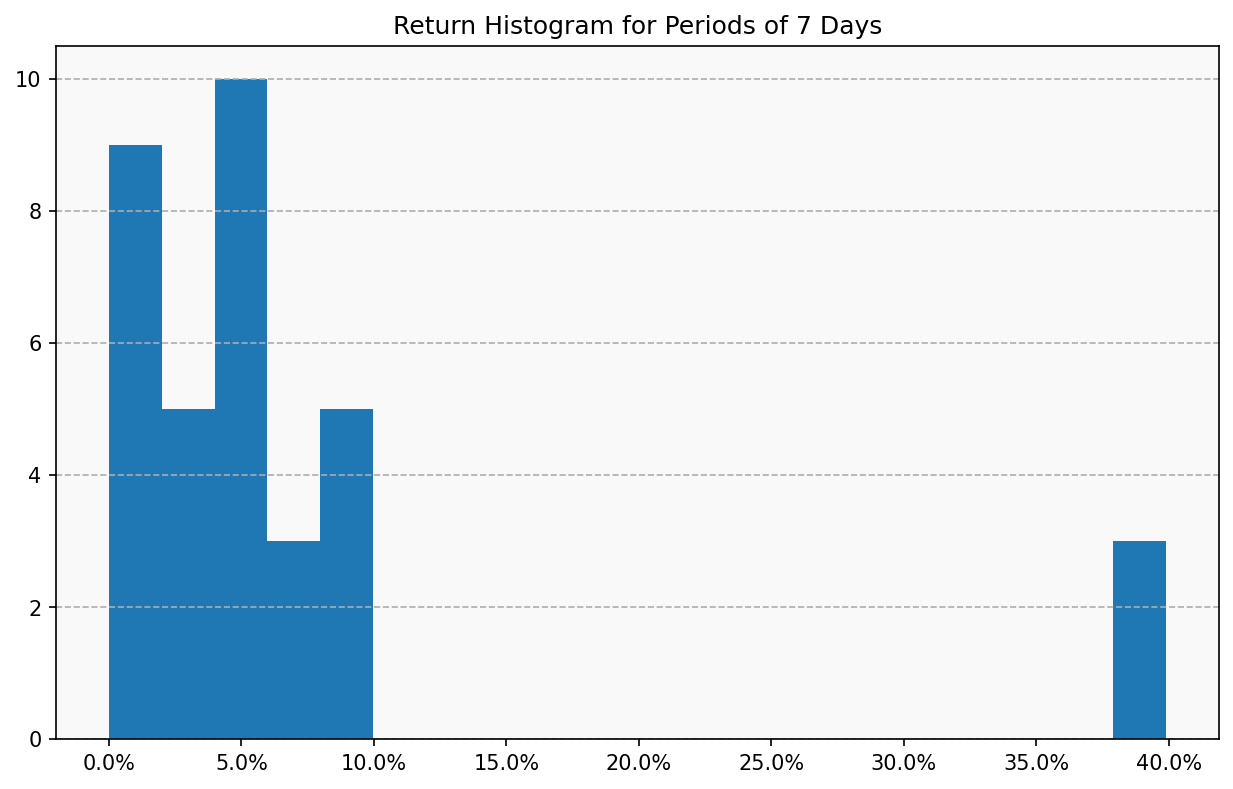

In [26]:
# Returns Histogram
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.hist(weeklyProfitsCoefs, bins=20)
ax.set_facecolor('#' + 'f9'*3)
ax.yaxis.grid(True, linestyle='--', c="#adadad")

ax.set_title(f'Return Histogram for Periods of {WINDOW_SIZE} Days')

ax.xaxis.set_major_formatter(FuncFormatter(lambda y_val, pos: f"{y_val*100:0.1f}%"))

plt.show()